### Load hidden states

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import pickle
import os
import numpy as np

In [3]:
os.chdir("..")

In [4]:
np.random.seed(21)

In [5]:
base_name = "concat60"
base_name_2nd = "concat101"

In [6]:
N=300

In [7]:
with open(f"experiments/en_et_{base_name}/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_base = pickle.load(f) 

In [8]:
with open(f"experiments/en_et_{base_name_2nd}/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_base_2nd = pickle.load(f) 

In [9]:
with open(f"experiments/en_et_Europarl_ft/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_europarl = pickle.load(f)

with open(f"experiments/en_et_OpenSubtitles_ft/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_opensubs = pickle.load(f) 
    
with open(f"experiments/en_et_JRC-Acquis_ft/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_jrc = pickle.load(f)

with open(f"experiments/en_et_EMEA_ft/internals/data_encoded{N}.pkl", 'rb') as f:
    hiddens_emea = pickle.load(f) 

In [10]:
def compute_sent_reps(hiddens):
    # hiddens: N x L x 1 x sen_len x emb_size
    for i, n in enumerate(hiddens):
        for j, l in enumerate(n):
            hiddens[i][j] = l.squeeze(0).mean(0)

In [11]:
def transpose_pylists_dict(d):
    for k,v in d.items():
        d[k] = np.array(list(map(list, zip(*v))))
    return d

In [12]:
for k, v in hiddens_base.items():
    compute_sent_reps(v)
    
for k, v in hiddens_base_2nd.items():
    compute_sent_reps(v)

for k, v in hiddens_europarl.items():
    compute_sent_reps(v)

for k, v in hiddens_opensubs.items():
    compute_sent_reps(v)

for k, v in hiddens_jrc.items():
    compute_sent_reps(v)

for k, v in hiddens_emea.items():
    compute_sent_reps(v)

In [13]:
hiddens_base = transpose_pylists_dict(hiddens_base)
hiddens_base_2nd = transpose_pylists_dict(hiddens_base_2nd)

hiddens_europarl = transpose_pylists_dict(hiddens_europarl)
hiddens_opensubs = transpose_pylists_dict(hiddens_opensubs)
hiddens_jrc = transpose_pylists_dict(hiddens_jrc)
hiddens_emea = transpose_pylists_dict(hiddens_emea)

In [14]:
from da.similarity import compute_similarity

In [15]:
a = copy.deepcopy(hiddens_europarl['Europarl'][5])

In [16]:
float(compute_similarity(a, hiddens_europarl['Europarl'][5], 'cka'))

1.0

In [17]:
def metric_encoder(h1, h2, sim):
    num_layers = int(len(h1))
    res = []
    for i in range(num_layers):
        res.append(compute_similarity(h1[i], h2[i], sim))
    return res

In [18]:
# %%time
# import numpy, pyrsa
# data1 = pyrsa.data.Dataset(hiddens_base['Europarl'][5])
# data2 = pyrsa.data.Dataset(hiddens_europarl['Europarl'][5])

# rdm1 = pyrsa.rdm.calc_rdm(data1)
# rdm2 = pyrsa.rdm.calc_rdm(data2)

# pyrsa.rdm.compare(rdm1, rdm2)
# #pyrsa.vis.show_rdm(rdms)

In [19]:
domain_names = ["Europarl", "OpenSubtitles", "JRC-Acquis", "EMEA"]
labels = ["m-101", "m-Europarl", "m-OpenSubtitles", "m-JRC-Acquis", "m-EMEA"]

metric_results = {}
metrics = ["cka"]

for metric in metrics:
    print()
    print(metric)
    
    cca_like = {}
    for domain in domain_names:
        print(domain)

        hid_b = hiddens_base[domain]
        hid_b2 = hiddens_base_2nd[domain]

        hid_europarl = hiddens_europarl[domain]
        hid_opensubs = hiddens_opensubs[domain]
        hid_jrc = hiddens_jrc[domain]
        hid_emea = hiddens_emea[domain]

        arr = []
        for hid2 in [hid_b2, hid_europarl, hid_opensubs, hid_jrc, hid_emea]:
            arr.append(metric_encoder(hid_b, hid2, metric))

        cca_like[domain] = arr
    
    metric_results[metric] = cca_like


cka
Europarl
OpenSubtitles
JRC-Acquis
EMEA


# plot

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

In [21]:

sns.set(font_scale=2)
sns.set_style("white")
sns.set_palette("tab10")

In [22]:
import matplotlib.pyplot as plt
plt.style.use(['science', 'no-latex', 'grid'])

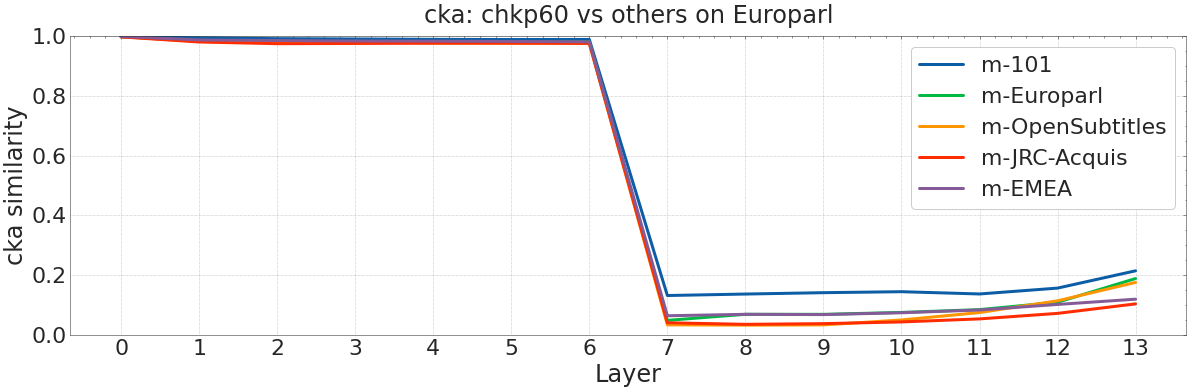

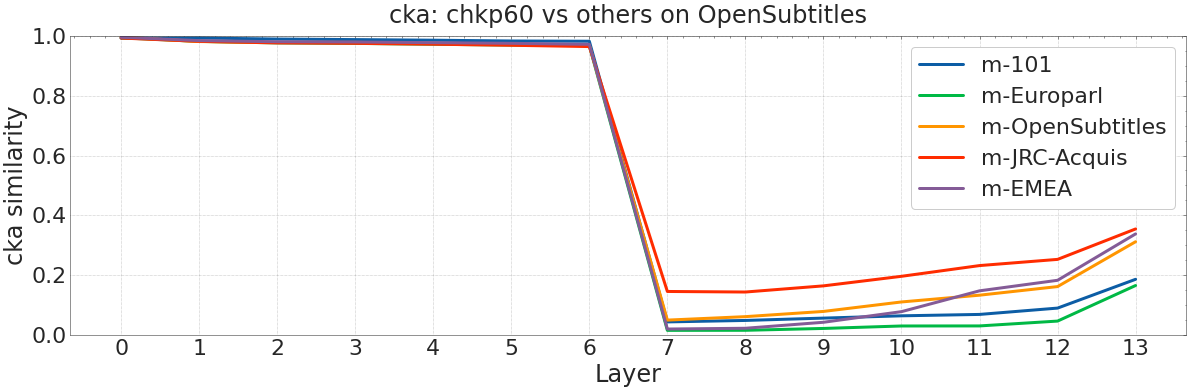

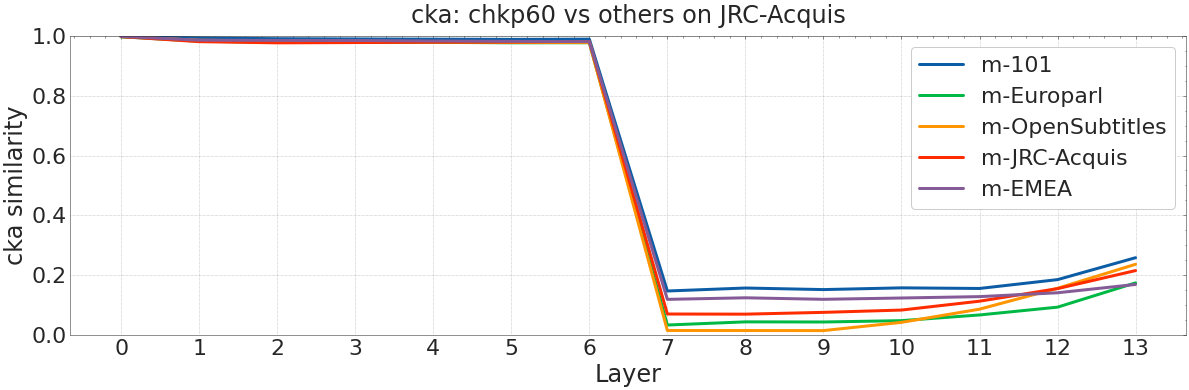

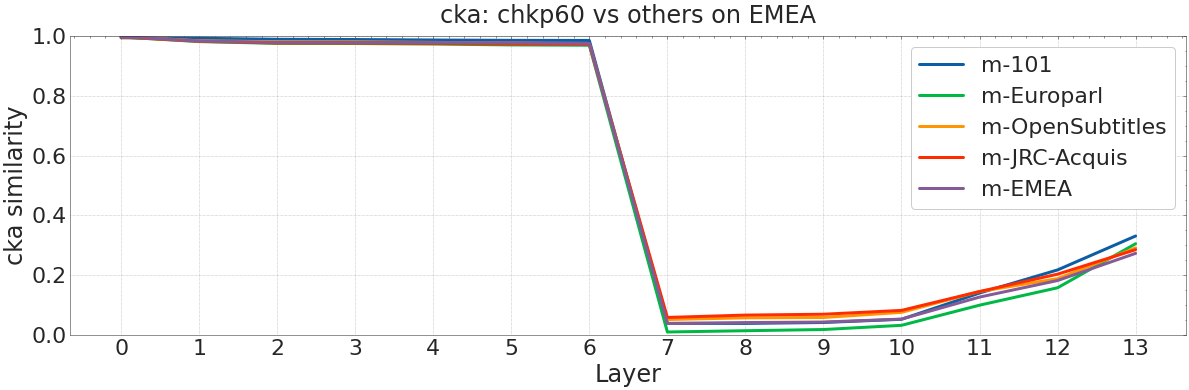

In [24]:
for metric, vals in metric_results.items():
#fig, axs = plt.subplots(1, 4, figsize=(20,5.5))    
    i = 0
    for data_k, val in vals.items():
        fig, ax = plt.subplots(1, 1, figsize=(20,5.5))
        #ax = axs[i]
        for arr, lbl in zip(val, labels):
            ax = sns.lineplot(x=list(range(len(arr))), y=arr, ax=ax, label=lbl, linewidth=3)

        ax.set_xticks(list(range(len(arr))))
        ax.set_title(f"{metric}: chkp60 vs others on {data_k}", y=1.025)
        ax.set_ylabel(f"{metric} similarity")
        ax.set_xlabel("Layer")
        ax.set_ylim(0,1)
        ax.grid(True)
        #ax.legend(frameon=True, loc = 'upper left')#, bbox_to_anchor = (1.0, 0.5))

    #fig.savefig("plots/abstraction_pattern_tuned_pawsx_multiling.pdf", bbox_inches='tight')

    # plt.title("xlm-roberta-base representations similarity for language pairs")

The sentences that decoder works with are different for each checkpoint based on NMT embeddings; they are probably far from paraphrases